<a href="https://colab.research.google.com/github/SYWoo02/KNU_Capstone_Project_2025/blob/main/%EC%98%88%EC%B8%A1_%EB%AA%A8%EB%8D%B8_%EA%B5%AC%ED%98%84%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 성인병 관련 약물 상호작용 다중분류 모델 구현

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# 라이브러리 및 데이터 불러오기
data = pd.read_csv("성인병 관련 약물조합 w interaction_type(label).csv")
data = data.drop('Unnamed: 0', axis=1)
data.tail(5)

,Disease1,Drug1_ID,Drug1_Name,Disease2,Drug2_ID,Drug2_Name,Label
5214,고혈압,DB09242,Moxonidine,당뇨병,DB08907,Canagliflozin,113
5215,고혈압,DB09477,Enalaprilat,당뇨병,DB06292,Dapagliflozin,113
5216,고혈압,DB09477,Enalaprilat,당뇨병,DB08907,Canagliflozin,102
5217,고혈압,DB11738,Rilmenidine,당뇨병,DB02638,Terlipressin,75
5218,고혈압,DB12945,Dihydralazine,당뇨병,DB02638,Terlipressin,75


In [31]:
data[data['Label'] == 53]

,Disease1,Drug1_ID,Drug1_Name,Disease2,Drug2_ID,Drug2_Name,Label
5063,고혈압,DB01118,Amiodarone,당뇨병,DB00104,Octreotide,53
5065,고혈압,DB01118,Amiodarone,당뇨병,DB06663,Pasireotide,53


## RandomForest

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Label 분포 확인 및 1개만 있는 클래스 제외
label_counts = data['Label'].value_counts()
# print(label_counts)

labels_to_keep = label_counts[label_counts > 1].index
RF_data = data[data['Label'].isin(labels_to_keep)]
# print(RF_data)

# 예측변수(Drug1과 2의 ID만 이용), 반응변수 분리
X = RF_data[['Drug1_ID', 'Drug2_ID']].copy()
y = RF_data["Label"]

# 범주형 예측변수 인코딩
drug1 = LabelEncoder()
drug2 = LabelEncoder()
X['Drug1_ID'] = drug1.fit_transform(X['Drug1_ID'])
X['Drug2_ID'] = drug2.fit_transform(X['Drug2_ID'])

# train과 test 분리 (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# RandomForestClassifier로 학습
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train, y_train)

# 예측 및 성능평가
y_pred = RF.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

# 결과 정리
# 정확도: 69%
# 다수 클래스(Label 75, 113 등)에서는 좋은 점수를 보임
# but, 소수 클래스(Label 1, 10, 12, 28 등)에서는 0점 또는 낮은 점수

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           3       0.68      0.56      0.61        70
           5       0.36      0.32      0.34        28
          10       0.25      0.33      0.29         6
          12       0.15      0.25      0.19        12
          20       0.50      0.22      0.31         9
          28       0.00      0.00      0.00         2
          47       0.75      0.69      0.72        39
          49       0.00      0.00      0.00         2
          53       0.00      0.00      0.00         0
          54       0.00      0.00      0.00         1
          55       0.50      0.43      0.46         7
          57       0.25      0.14      0.18        35
          60       0.38      0.31      0.34        16
          63       0.50      0.33      0.40         3
          74       0.00      0.00      0.00         3
          75       0.80      0.89      0.84       524
          80       1.00    

## XGBoost

In [39]:
from xgboost import XGBClassifier

# 범주형 설명변수 인코딩
label = LabelEncoder()
y_encoded = label.fit_transform(y)

# train과 test 분리 (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y
)

# XGBoostClassifier로 학습
xgb = XGBClassifier(
    n_estimators=100,
    random_state=42,
    eval_metric='mlogloss'
)
xgb.fit(X_train, y_train)

# 예측 및 평가
y_pred = xgb.predict(X_test)

# 다시 원래 Label로 복원
y_test_orig = label.inverse_transform(y_test)
y_pred_orig = label.inverse_transform(y_pred)

print(classification_report(y_test_orig, y_pred_orig, zero_division=0))

# 결과 정리
# 정확도: 89%
# 다수 클래스(Label 75, 113 등)에서는 좋은 점수를 보임
# but, 여전히 몇몇 개의 소수 클래스(Label 28, 49, 74 등)에서는 0점 또는 낮은 점수

              precision    recall  f1-score   support

           1       1.00      0.75      0.86         4
           3       0.80      0.84      0.82        70
           5       0.93      1.00      0.97        28
          10       0.67      0.33      0.44         6
          12       0.67      0.50      0.57        12
          20       0.88      0.78      0.82         9
          28       0.00      0.00      0.00         2
          47       0.94      0.87      0.91        39
          49       0.00      0.00      0.00         2
          54       0.00      0.00      0.00         1
          55       0.78      1.00      0.88         7
          57       1.00      0.97      0.99        35
          60       0.83      0.94      0.88        16
          63       0.33      0.33      0.33         3
          74       0.00      0.00      0.00         3
          75       0.92      0.97      0.95       524
          80       0.00      0.00      0.00         2
          81       0.00    

## MLP (라이브러리 이용)

In [44]:
from sklearn.neural_network import MLPClassifier

# MLPClassifier로 학습
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),   # 은닉층 크기
    activation='relu',              # 활성화 함수
    solver='adam',                  # 최적화 알고리즘
    max_iter=1000,
    random_state=42
)
mlp.fit(X_train, y_train)

# 예측 및 평가
y_pred = mlp.predict(X_test)

# 다시 원래 Label로 복원
y_test_orig = label.inverse_transform(y_test)
y_pred_orig = label.inverse_transform(y_pred)

print(classification_report(y_test_orig, y_pred_orig, zero_division=0))

# 결과 정리
# 정확도: 52%
# 다수 클래스(Label 75, 113 등)에서는 좋은 점수를 보임
# but, 여전히 몇몇 개의 소수 클래스(Label 28, 49, 74 등)에서는 0점 또는 낮은 점수

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           3       0.27      0.13      0.17        70
           5       0.00      0.00      0.00        28
          10       0.00      0.00      0.00         6
          12       0.00      0.00      0.00        12
          20       0.00      0.00      0.00         9
          28       0.00      0.00      0.00         2
          47       0.00      0.00      0.00        39
          49       0.00      0.00      0.00         2
          54       0.00      0.00      0.00         1
          55       0.00      0.00      0.00         7
          57       0.75      0.09      0.15        35
          60       0.00      0.00      0.00        16
          63       0.00      0.00      0.00         3
          74       0.00      0.00      0.00         3
          75       0.54      0.98      0.69       524
          80       0.00      0.00      0.00         2
          81       0.00    

## MLP (Manually)

Iter 0: Loss = 3.2188, Accuracy = 0.5019
Iter 100: Loss = 2.3021, Accuracy = 0.5019
Iter 200: Loss = 2.0350, Accuracy = 0.5019
Iter 300: Loss = 1.9534, Accuracy = 0.5019
Iter 400: Loss = 1.9114, Accuracy = 0.5019
Iter 500: Loss = 1.8883, Accuracy = 0.5019
Iter 600: Loss = 1.8763, Accuracy = 0.5019
Iter 700: Loss = 1.8699, Accuracy = 0.5019
Iter 800: Loss = 1.8662, Accuracy = 0.5019
Iter 900: Loss = 1.8639, Accuracy = 0.5019
Iter 1000: Loss = 1.8623, Accuracy = 0.5019
Iter 1100: Loss = 1.8612, Accuracy = 0.5019
Iter 1200: Loss = 1.8604, Accuracy = 0.5019
Iter 1300: Loss = 1.8598, Accuracy = 0.5019
Iter 1400: Loss = 1.8593, Accuracy = 0.5019
Iter 1500: Loss = 1.8589, Accuracy = 0.5019
Iter 1600: Loss = 1.8585, Accuracy = 0.5019
Iter 1700: Loss = 1.8582, Accuracy = 0.5019
Iter 1800: Loss = 1.8579, Accuracy = 0.5019
Iter 1900: Loss = 1.8576, Accuracy = 0.5019
Iter 2000: Loss = 1.8573, Accuracy = 0.5019
Iter 2100: Loss = 1.8570, Accuracy = 0.5019
Iter 2200: Loss = 1.8567, Accuracy = 0.5019


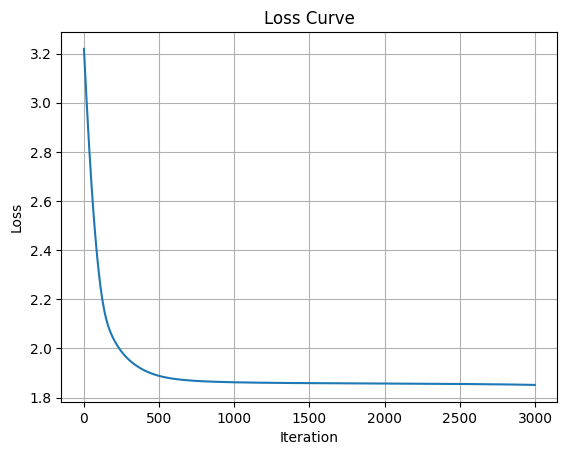

In [54]:
ohe = OneHotEncoder(sparse_output=False)
X_ohe = ohe.fit_transform(X)

# NeuralNet용 데이터 형태 변환
X_np = X_ohe.T  # (2, sample 수)
num_samples = X_np.shape[1]
num_features = X_np.shape[0]

num_classes = len(np.unique(y_encoded))
y_onehot = np.eye(num_classes)[y_encoded]

# NeuralNet 클래스 정의
class NeuralNet:
    def __init__(self, batch_size, cf):
        np.random.seed(1122)
        self.d_size = batch_size
        self.w1 = np.random.normal(0, 0.05, (cf[1], cf[0]))
        self.b1 = np.zeros((cf[1], 1))
        self.w2 = np.random.normal(0, 0.05, (cf[2], cf[1]))
        self.b2 = np.zeros((cf[2], 1))
        self.w3 = np.random.normal(0, 0.05, (cf[3], cf[2]))
        self.b3 = np.zeros((cf[3], 1))
        self.w4 = np.random.normal(0, 0.05, (cf[4], cf[3]))
        self.b4 = np.zeros((cf[4], 1))

    def relu(self, z):
        return np.maximum(0, z)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    def forward(self, x):
        z1 = np.dot(self.w1, x) + self.b1
        a1 = self.relu(z1)
        z2 = np.dot(self.w2, a1) + self.b2
        a2 = self.relu(z2)
        z3 = np.dot(self.w3, a2) + self.b3
        a3 = self.relu(z3)
        z4 = np.dot(self.w4, a3) + self.b4
        a4 = self.softmax(z4)
        return a1, a2, a3, a4

    def update(self, x, lr, y):
        a1, a2, a3, a4 = self.forward(x)
        delta4 = a4 - y
        delta3 = np.dot(self.w4.T, delta4) * (a3 > 0)
        delta2 = np.dot(self.w3.T, delta3) * (a2 > 0)
        delta1 = np.dot(self.w2.T, delta2) * (a1 > 0)
        self.w4 -= lr * np.dot(delta4, a3.T) / self.d_size
        self.b4 -= lr * np.mean(delta4, axis=1, keepdims=True)
        self.w3 -= lr * np.dot(delta3, a2.T) / self.d_size
        self.b3 -= lr * np.mean(delta3, axis=1, keepdims=True)
        self.w2 -= lr * np.dot(delta2, a1.T) / self.d_size
        self.b2 -= lr * np.mean(delta2, axis=1, keepdims=True)
        self.w1 -= lr * np.dot(delta1, x.T) / self.d_size
        self.b1 -= lr * np.mean(delta1, axis=1, keepdims=True)

    def predict(self, x):
        _, _, _, a4 = self.forward(x)
        return np.argmax(a4, axis=0)

    def accuracy(self, x, y_true):
        y_pred = self.predict(x)
        return np.mean(y_pred == y_true)

    def final_parameter(self):
        print("Final Parameter - w4:", self.w4)
        print("Final Parameter - b4:", self.b4)

# 모델 학습
config_layer = [num_features, 30, 20, 10, num_classes]
learning_rate = 0.05
model = NeuralNet(num_samples, config_layer)

loss_history = []
for iter in range(3000):
    a1, a2, a3, a4 = model.forward(X_np)
    model.update(X_np, learning_rate, y_onehot.T)
    loss = -np.mean(np.sum(y_onehot.T * np.log(a4 + 1e-15), axis=0))
    loss_history.append(loss)
    if iter % 100 == 0:
        acc = model.accuracy(X_np, y_encoded)
        print(f"Iter {iter}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")

# 최종 결과
# model.final_parameter()
final_acc = model.accuracy(X_np, y_encoded)
print(f"최종 정확도: {final_acc:.4f}")

# Loss Curve
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.grid(True)
plt.show()